### Import Library

In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time 
import matplotlib.pyplot as plt

### Import Data

In [119]:
X = pd.read_csv('dataset/fitur.csv').values
y = pd.read_csv('dataset/target.csv').values.flatten()

### Split Data

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Modeling BBA-SVM

In [121]:
class BBA_SVM:
    def __init__(self, n_bats, n_features, max_iter, f_min, f_max, alpha, gamma):
        self.n_bats = n_bats
        self.n_features = n_features
        self.max_iter = max_iter
        self.f_min = f_min
        self.f_max = f_max
        self.alpha = alpha
        self.gamma = gamma

        # inisialisasi posisi, kecepatan, frekuensi, pulse rate, dan loudness
        self.positions = np.random.randint(2, size=(n_bats, n_features))
        self.velocities = np.zeros((n_bats, n_features))
        self.frequencies = np.zeros(n_bats)
        self.loudness = np.random.uniform(1, 2.000001, size=n_bats)
        self.pulse_rate = np.random.rand(n_bats)
        self.pulse_rate_initial = self.pulse_rate.copy()
        self.fitness_values = np.full(n_bats, -np.inf)

        # inisialisasi global best
        self.global_best_position = self.positions[0].copy()
        self.global_best_fitness = self.fitness(self.global_best_position)
        for i in range(self.n_bats):
            fitness = self.fitness(self.positions[i])
            if fitness > self.global_best_fitness:
                self.global_best_fitness = fitness
                self.global_best_position = self.positions[i].copy()

    # fungsi sigmoid / untuk perpindahan posisi partikel secara biner
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # fungsi objektif / fitness dengan SVM
    def fitness(self, position):
        selected_features = np.where(position == 1)[0]
        # pinalti jika tidak ada fitur yang terpilih
        if len(selected_features) == 0:
            return 0

        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]

        model = SVC(kernel='linear', C=10, gamma=0.1, random_state=42)
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return accuracy_score(y_test, y_pred)

    # fungsi optimasi BAA
    def optimize(self):
        for t in range(self.max_iter):
            for i in range(self.n_bats):
                # memperbarui frekuensi
                beta = np.random.rand()
                self.frequencies[i] = self.f_min + (self.f_max - self.f_min) * beta

                # memperbarui kecepatan
                self.velocities[i] += (self.global_best_position - self.positions[i]) * self.frequencies[i]
                # memperbarui posisi
                new_position = (np.random.rand(self.n_features) < self.sigmoid(self.velocities[i])).astype(int)

                # mengenerate posisi baru / lokal
                if np.random.rand() > self.pulse_rate[i]:
                    epsilon = np.random.uniform(-1, 1.000001, size=self.n_features)
                    new_position = self.global_best_position + epsilon * np.mean(self.loudness)
                    new_position = (np.random.rand(self.n_features) < self.sigmoid(new_position)).astype(int)

                # menghitung fitness
                new_fitness = self.fitness(new_position)

                # terima solusi baru jika meningkatkan fitness dan memenuhi ambang probabilitas
                if np.random.rand() < self.loudness[i] and new_fitness > self.fitness_values[i] :
                    self.positions[i] = new_position
                    self.fitness_values[i] = new_fitness

                    # memperbarui loudness and pulse rate
                    self.loudness[i] *= self.alpha
                    self.pulse_rate[i] *= self.pulse_rate_initial[i] * (1 - np.exp(-self.gamma * t))

                # memperbarui global best
                if new_fitness > self.global_best_fitness:
                    self.global_best_fitness = new_fitness
                    self.global_best_position = new_position

            print(f"Iteration {t + 1}/{self.max_iter}: Best Fitness = {self.global_best_fitness}")

        print("OPTIMASI SELESAI")
        return self.global_best_position, self.global_best_fitness

### Pengujian

##### Pengaruh jumlah bat terhadap akurasi dan waktu komputasi

In [122]:
def tuning():
    n_bats_values = list(range(1, 100, 2))
    n_features = X.shape[1]
    max_iter_values = [20]
    f_min_values = [0] 
    f_max_values = [1]
    alpha_values = [0.8] 
    gamma_values = [0.9]

    bats_list = []
    best_position_list = []
    best_features_list = []
    best_fitness_list = []
    duration_list = []

    i = 0
    for n_bats in n_bats_values:
        for max_iter in max_iter_values:
            for f_min in f_min_values:
                for f_max in f_max_values:
                    for alpha in alpha_values:
                        for gamma in gamma_values:
                            i += 1
                            print(f"KOMBINASI KE-{i}/{len(n_bats_values)}, N_BAT = {n_bats}")
                            start_time = time.time()
                            # inisialisasi bba
                            bba = BBA_SVM(
                                n_bats=n_bats,
                                n_features=n_features,
                                max_iter=max_iter,
                                f_min=f_min,
                                f_max=f_max,
                                alpha=alpha,
                                gamma=gamma
                            )
                            # optimasi
                            best_position, best_fitness = bba.optimize()
                            end_time = time.time()
                            durasi = end_time - start_time
                            best_features = np.where(best_position == 1)[0]
                            # simpan ke list
                            bats_list.append(n_bats)
                            best_position_list.append(best_position)
                            best_features_list.append(best_features)
                            best_fitness_list.append(best_fitness) 
                            duration_list.append(durasi) 
    hasil = pd.DataFrame({
        'n_bats': bats_list, 
        'best_position': best_position_list,
        'best_features': best_features_list,
        'best_fitness': best_fitness_list,
        'duration': duration_list
    })                                 
    return hasil

##### Runing tuning

In [123]:
fitness_list = []
duration_list = []
n_tuning = 50

for i in range(n_tuning):
    print(f"\nRUNING KE-{i+1}/{n_tuning} | LET'S GO!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    jumlahBAT = tuning()
    fitness_list.append(jumlahBAT[['n_bats', 'best_fitness']])
    duration_list.append(jumlahBAT[['n_bats', 'duration']])


RUNING KE-1/50 | LET'S GO!!!!!!!!!!!!!!!!!!!!!!!!!!!!
KOMBINASI KE-1/50, N_BAT = 1
Iteration 1/20: Best Fitness = 0.9078947368421053
Iteration 2/20: Best Fitness = 0.9078947368421053


Iteration 3/20: Best Fitness = 0.9078947368421053
Iteration 4/20: Best Fitness = 0.9078947368421053
Iteration 5/20: Best Fitness = 0.9078947368421053
Iteration 6/20: Best Fitness = 0.9078947368421053
Iteration 7/20: Best Fitness = 0.9078947368421053
Iteration 8/20: Best Fitness = 0.9078947368421053
Iteration 9/20: Best Fitness = 0.9078947368421053
Iteration 10/20: Best Fitness = 0.9078947368421053
Iteration 11/20: Best Fitness = 0.9078947368421053
Iteration 12/20: Best Fitness = 0.9078947368421053
Iteration 13/20: Best Fitness = 0.9078947368421053
Iteration 14/20: Best Fitness = 0.9078947368421053
Iteration 15/20: Best Fitness = 0.9078947368421053
Iteration 16/20: Best Fitness = 0.9078947368421053
Iteration 17/20: Best Fitness = 0.9078947368421053
Iteration 18/20: Best Fitness = 0.9078947368421053
Iteration 19/20: Best Fitness = 0.9078947368421053
Iteration 20/20: Best Fitness = 0.9078947368421053
OPTIMASI SELESAI
KOMBINASI KE-2/50, N_BAT = 3
Iteration 1/20: Best Fitness = 0.9078947368

KeyboardInterrupt: 

In [102]:
fitness_df = pd.concat(fitness_list)
duration_df = pd.concat(duration_list)
fitness_df.to_csv('hasil uji/bat-fitness.csv', index=False)
duration_df.to_csv('hasil uji/bat-duration.csv', index=False)

# rerata fitness n_bats
avg_fitness = fitness_df.groupby('n_bats')['best_fitness'].mean().reset_index()

# rerata duration n_bats
avg_duration = duration_df.groupby('n_bats')['duration'].mean().reset_index()

avg_fitness.to_csv('hasil uji/bat-avg_fitness.csv', index=False)
avg_duration.to_csv('hasil uji/bat-avg_duration.csv', index=False)

In [103]:
avg_fitness

,n_bats,best_fitness
0,1,0.930263
1,3,0.941447
2,5,0.944079
3,7,0.948026
4,9,0.951316
5,11,0.951316
6,13,0.950658
7,15,0.955921
8,17,0.954605
9,19,0.955263


In [104]:
avg_duration

,n_bats,duration
0,1,1.165407
1,3,3.390172
2,5,5.739152
3,7,7.736555
4,9,9.895197
5,11,12.038042
6,13,13.965201
7,15,16.117719
8,17,18.155317
9,19,20.446629


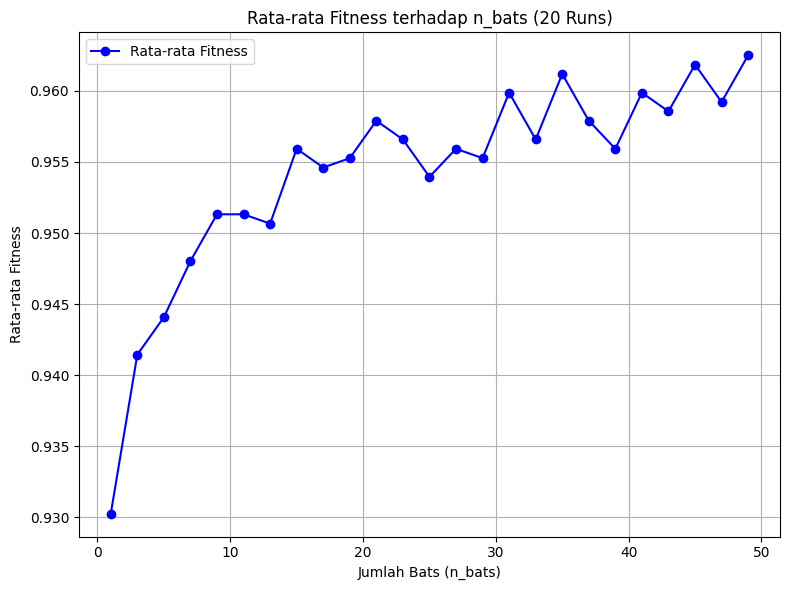

In [111]:
plt.figure(figsize=(8, 6))
plt.plot(avg_fitness['n_bats'], avg_fitness['best_fitness'], marker='o', color='blue', label='Rata-rata Fitness')
plt.title('Rata-rata Fitness terhadap n_bats (20 Runs)')
plt.xlabel('Jumlah Bats (n_bats)')
plt.ylabel('Rata-rata Fitness')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

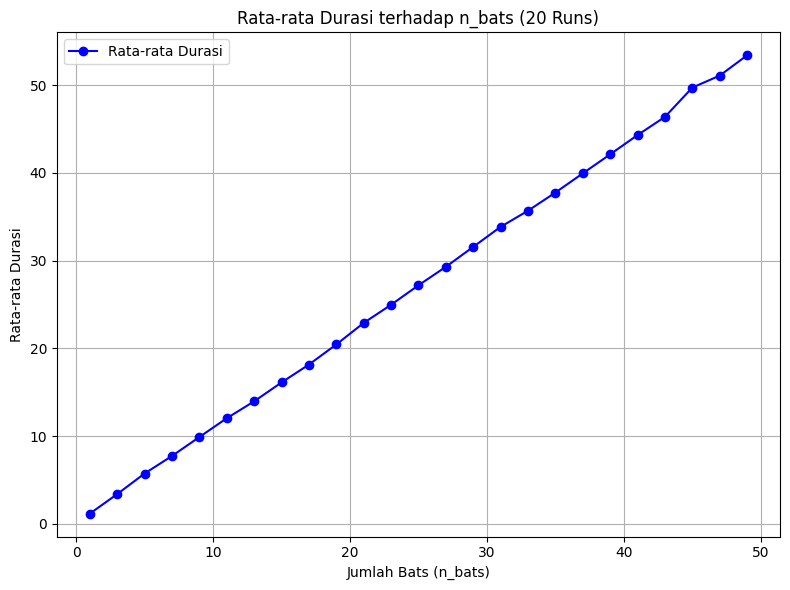

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(avg_duration['n_bats'], avg_duration['duration'], marker='o', color='blue', label='Rata-rata Durasi')
plt.title('Rata-rata Durasi terhadap n_bats (20 Runs)')
plt.xlabel('Jumlah Bats (n_bats)')
plt.ylabel('Rata-rata Durasi')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()